# Kernel Methods

Assignment for the [foundations of machine learning course](https://bloomberg.github.io/foml/#home).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy.spatial
import functools

%matplotlib inline

## Kernalization: an overview

Consider the following optimization problem on a data set $(x_1, y_1),...,(x_n; y_n) \in R^d \times Y$:  

$$min_{w \in R^d}R(\sqrt{\langle w,w \rangle}) + L(\langle w,x_1 \rangle , ... , \langle w,x_n \rangle)$$  

where $w, x_1,...,x_n \in R^d$, and $\langle \cdot,\cdot \rangle$ is the standard inner product on $R^d$.   
- The function $R : [0,\infty) \to R$ is nondecreasing: regularization term 
- $L : R^n \to R$ is arbitrary: loss term. 

This general form includes soft-margin SVM and ridge regression, though not lasso regression.  

Using the representer theorem, we showed that if the optimization problem has a solution, there is always a solution of the form $w = \sum_{i=1}^n \alpha_i x_i$, for some $\alpha \in R^n$.  
  
Plugging this into the our original problem, we get the following “kernelized” optimization problem:
min
$$min_{\alpha \in R^n}R(\sqrt{\alpha^T K \alpha}) + L(K\alpha)$$ 
  
where $K \in R^{n\times n}$ is the Gram matrix (or “kernel matrix”) defined by $K_{ij} = k(x_i, x_j) = \langle x_i, x_j \rangle$.  

Predictions are given by $$ f(x) = \sum_{i=1}^n \alpha_i k(x_i,x) $$  

and we can recover the original $w \in R^d$ by $w = \sum_{i=1}^n \alpha_i x_i$  

The “kernel trick” is to swap out occurrences of the kernel $k$ (and the corresponding Gram matrix $K$) with another kernel. For example, we could replace $k(x_i, x_j) = \langle x_i, x_j \rangle$ by  $k'(x_i, x_j) = \langle \psi(x_i), \psi(x_j) \rangle$  for an arbitrary feature mapping $\psi: R^d \to R^D$. In this case, the recovered $w \in R^D$ would be $w = \sum_{i=1}^n \alpha_i \psi(x_i)$ and predictions would be $\langle w, \psi(x_i) \rangle$.  

More interestingly, we can replace $k$ by another kernel $k''(x_i, x_j)$ for which we do not even know or cannot explicitly write down a corresponding feature map $\psi$. Our main example of this is the RBF kernel
$$k(x, x') = exp(-\frac{\| x-x' \|^2}{2\sigma ^2}),  $$


for which the corresponding feature map $\psi$ is infinite dimensional. In this case, we cannot recover $w$ since it would be infinite dimensional. Predictions must be done using $\alpha \in R^n$, with $f(x) = \sum_{i=1}^n \alpha_i k(x_i,x).$  
  
  
Your implementation of kernelized methods below should not make any reference to $w$ or to a feature map $\psi$ . Your “learning” routine should return $\alpha$, rather than $w$, and your prediction function should also use $\alpha$ rather than $w$. This will allow us to work with kernels that correspond to infinite-dimensional feature vectors.

## Kernels and Kernel machines

Implementation of different kernels. We assume that our input space is $\chi = R^d$, therefore we can represent a collection of n inputs in a matrix $X \in R^{n\times d}$.

### RBF kernel

$$k_{RBF(\sigma)}(x, x') = exp(-\frac{\| x-x' \|^2}{2\sigma ^2}) $$


In [2]:
def RBF_kernel(X1,X2,sigma):
    """
    Computes the RBF kernel between two sets of vectors   
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        sigma - the bandwidth (i.e. standard deviation) for the RBF/Gaussian kernel
    Returns:
        matrix of size n1xn2, with exp(-||x1_i-x2_j||^2/(2 sigma^2)) in position i,j
    """
    return np.exp(-scipy.spatial.distance.cdist(X1,X2,metric='sqeuclidean')/(2*sigma**2))

### Linear kernel

$$k_{linear}(x, x') = \langle x,x' \rangle $$


In [3]:
def linear_kernel(X1, X2):
    """
    Computes the linear kernel between two sets of vectors.
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
    Returns:
        matrix of size n1xn2, with x1_i^T x2_j in position i,j
    """
    return np.dot(X1,np.transpose(X2))

### Polynomial kernel

$$k_{poly(a,d}(x, x') = (a + \langle x,x' \rangle)^d $$

In [4]:
def polynomial_kernel(X1, X2, offset, degree):
    """
    Computes the inhomogeneous polynomial kernel between two sets of vectors
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        offset, degree - two parameters for the kernel
    Returns:
        matrix of size n1xn2, with (offset + <x1_i,x2_j>)^degree in position i,j
    """
    return (offset + np.dot(X1,np.transpose(X2)))**degree

In [5]:
X_0 = np.array([-4, -1, 0, 2]).reshape(-1,1)

linear_kernel(X_0,X_0)

array([[16,  4,  0, -8],
       [ 4,  1,  0, -2],
       [ 0,  0,  0,  0],
       [-8, -2,  0,  4]])

### Plot of basis functions

Text(0.5, 1.0, 'Polynomial kernel')

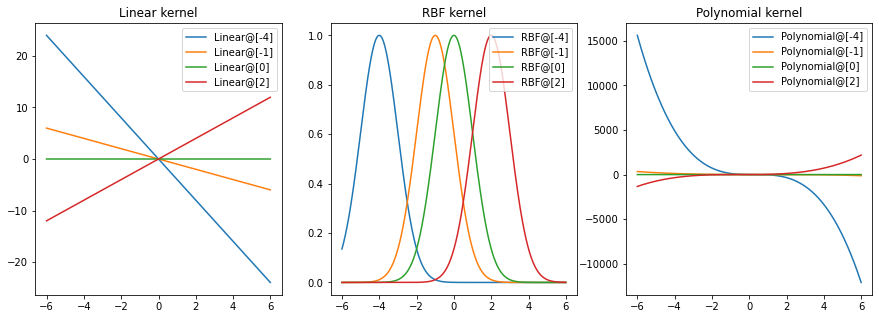

In [6]:
plot_step = .01
xpts = np.arange(-6.0, 6, plot_step).reshape(-1,1)
X_0 = np.array([-4, -1, 0, 2]).reshape(-1,1)

fig, ax = plt.subplots(1,3, figsize=(15,5))

# Linear kernel
y = linear_kernel(X_0, xpts) 
for i in range(len(X_0)):
    label = "Linear@"+str(X_0[i,:])
    ax[0].plot(xpts, y[i,:], label=label)
ax[0].legend(loc = 'upper right')
ax[0].set_title('Linear kernel') 

# RBF kernel
y = RBF_kernel(X_0, xpts, 1) 
for i in range(len(X_0)):
    label = "RBF@"+str(X_0[i,:])
    ax[1].plot(xpts, y[i,:], label=label)
ax[1].legend(loc = 'upper right')
ax[1].set_title('RBF kernel') 

# Polynomial kernel
y = polynomial_kernel(X_0, xpts,1,3) 
for i in range(len(X_0)):
    label = "Polynomial@"+str(X_0[i,:])
    ax[2].plot(xpts, y[i,:], label=label)
ax[2].legend(loc = 'upper right')
ax[2].set_title('Polynomial kernel') 

### Kernel machines

By the representer theorem, the final prediction function will be of the form  $ f(x) = \sum_{i=1}^n \alpha_i k(x_i,x) $ , where $x_1,..,x_n \in \chi$ are the inputs in the training set. This is a special case of what is sometimes called a kernel machine.

A **kernel machine** is a linear model with kernelized feature vectors.  
It is a function of the form $ f(x) = \sum_{i=1}^r \alpha_i k(\mu_i,x) $, where $\mu_1,...,\mu_r \in \chi$ are called **prototypes** or **centroids**.

In the special case that the kernel is an RBF kernel, we get what’s called an **RBF Network** (proposed by Broomhead and Lowe in 1988).  
  
We can see that the prediction functions we get from our kernel methods will be kernel machines in which each input in the training set $x_1,..,x_n$ serves as a prototype point.

In [7]:
class Kernel_Machine(object):
    def __init__(self, kernel, prototype_points, weights):
        """
        Args:
            kernel(X1,X2) - a function return the cross-kernel matrix between rows of X1 and rows of X2 for kernel k
            prototype_points - an Rxd matrix with rows mu_1,...,mu_R
            weights - a vector of length R with entries w_1,...,w_R
        """

        self.kernel = kernel
        self.prototype_points = prototype_points
        self.weights = weights
        
    def predict(self, X):
        """
        Evaluates the kernel machine on the points given by the rows of X
        Args:
            X - an nxd matrix with inputs x_1,...,x_n in the rows
        Returns:
            Vector of kernel machine evaluations on the n points in X.  Specifically, jth entry of return vector is
                Sum_{i=1}^R w_i k(x_j, mu_i)
        """
        
        return np.dot(self.kernel(X,self.prototype_points), self.weights)

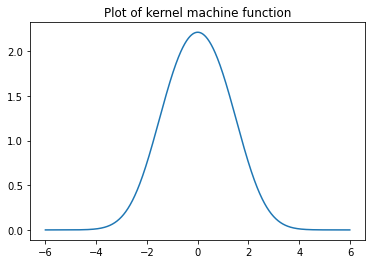

In [8]:
# Plot kernel machine function

plot_step = .01
xpts = np.arange(-6.0, 6, plot_step).reshape(-1,1)
prototypes = np.array([-1,0,1]).reshape(-1,1)
wgts = np.array([1,1,1])

kernel = functools.partial(RBF_kernel, sigma=1)
rbf = Kernel_Machine(kernel=kernel, prototype_points=prototypes, weights=wgts)
predictions = rbf.predict(xpts)

plt.plot(xpts, predictions)
plt.title('Plot of kernel machine function')
plt.show() 

## Kernel ridge regression

One-dimensional regression problem , in which $X = Y = A = R$.  
Training data provided in the assignment.  
Data will be fitted using kernelized ridge regression, and we will compare hthe results using several different kernel functions. 

### Load the data

In [10]:
#Load train & test data; Convert to column vectors so it generalizes well to data in higher dimensions.

data_train,data_test = np.loadtxt("krr-train.txt"),np.loadtxt("krr-test.txt")
x_train, y_train = data_train[:,0].reshape(-1,1),data_train[:,1].reshape(-1,1)
x_test, y_test = data_test[:,0].reshape(-1,1),data_test[:,1].reshape(-1,1)

### Plot of the training data

Text(0, 0.5, 'y_train')

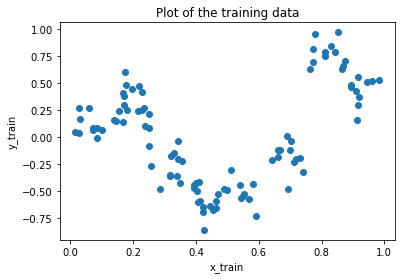

In [11]:
plt.scatter(x_train,y_train)
plt.title('Plot of the training data')
plt.xlabel('x_train')
plt.ylabel('y_train')

There is a clear relationship between x and y, the relationship is not linear.

### Kernelized ridge regression

In kernelized ridge regression, the final prediction function is $$ f(x) = \sum_{i=1}^n \alpha_i k(x_i,x) $$  
where $\alpha = (\lambda I + K)^{-1}y$ and $ K \in R^{n \times n}$ is the kernel matrix of the training data: $K_{ij} = k(x_i,x_j)$, for $x_1,...,x_n$.  
  
In terms of kernel machines, $\alpha_i$ is the weight on the kernel function evaluated at the prototype point $x_i$

In [12]:
def train_kernel_ridge_regression(X, y, kernel, l2reg):
    
    K = kernel(X,X)
    
    alpha = np.linalg.inv(l2reg*np.identity(X.shape[0]) + K)@y
    
    
    return Kernel_Machine(kernel, X, alpha)

### Hyperparameter optimization
#### Bandwidth

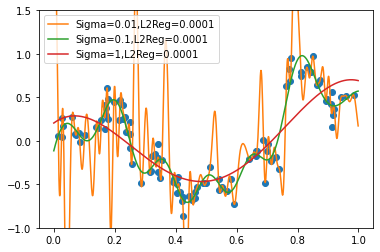

In [13]:
plot_step = .001
xpts = np.arange(0 , 1, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
l2reg = 0.0001
for sigma in [.01,.1,1]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
    label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.5)
plt.show()

Sigma = bandwidth. Bandwidth in kernel regression controls the degree of smoothing (controls variance and bias in the output).

You can see sigma as the standard deviation of the kernel evaluated at a given point. A small value of sigma corresponds to a narrow kernel. A small value of sigma (here 0.01) overfits the data because it generates a narrower kernel, which gives high weight to the ‘yi’ of ‘xi’ in the training data set when predicted for xi [source](https://towardsdatascience.com/kernel-regression-made-easy-to-understand-86caf2d2b844). 

High values of sigma means that means that each prediction is an average over many training points, which over-smooths the output resulting in underfitting.

#### Regularization parameter

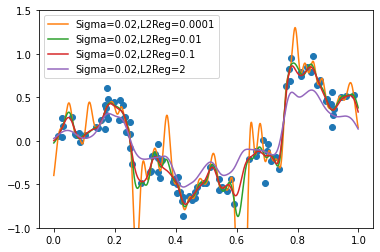

In [14]:
plot_step = .001
xpts = np.arange(0 , 1, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
sigma= .02
for l2reg in [.0001,.01,.1,2]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
    label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.5)
plt.show()

In ridge regression, the regularization term (lambda) regularizes the coefficients such that if the coefficients take large values the objective function is penalized. So penalization shrinks the coefficients.
Small value of lambda: there is no regularization, we overfit the data.  

#### Grid search

In [15]:
###Code provided in the assignment###
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin

class KernelRidgeRegression(BaseEstimator, RegressorMixin):  
    """sklearn wrapper for our kernel ridge regression"""
     
    def __init__(self, kernel="RBF", sigma=1, degree=2, offset=1, l2reg=1):        
        self.kernel = kernel
        self.sigma = sigma
        self.degree = degree
        self.offset = offset
        self.l2reg = l2reg 

    def fit(self, X, y=None):
        """
        This should fit classifier. All the "work" should be done here.
        """
        if (self.kernel == "linear"):
            self.k = linear_kernel
        elif (self.kernel == "RBF"):
            self.k = functools.partial(RBF_kernel, sigma=self.sigma)
        elif (self.kernel == "polynomial"):
            self.k = functools.partial(polynomial_kernel, offset=self.offset, degree=self.degree)
        else:
            raise ValueError('Unrecognized kernel type requested.')
        
        self.kernel_machine_ = train_kernel_ridge_regression(X, y, self.k, self.l2reg)

        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "kernel_machine_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        return(self.kernel_machine_.predict(X))

    def score(self, X, y=None):
        # get the average square error
        return(((self.predict(X)-y)**2).mean()) 

In [16]:
###Code provided in the assignment###
from sklearn.model_selection import GridSearchCV,PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error,make_scorer
import pandas as pd
    
test_fold = [-1]*len(x_train) + [0]*len(x_test)   #0 corresponds to test, -1 to train
predefined_split = PredefinedSplit(test_fold=test_fold)

In [17]:
###Code provided in the assignment###
param_grid = [{'kernel': ['RBF'],'sigma':[.1,1,10], 'l2reg': np.exp2(-np.arange(-5,5,1))},
              {'kernel':['polynomial'],'offset':[-1,0,1], 'degree':[2,3,4],'l2reg':[10, .1, .01] },
              {'kernel':['linear'],'l2reg': [10,1,.01]}]
kernel_ridge_regression_estimator = KernelRidgeRegression()
grid = GridSearchCV(kernel_ridge_regression_estimator, 
                    param_grid,
                    cv = predefined_split,
                    scoring = make_scorer(mean_squared_error,greater_is_better = False),
                    return_train_score = True
                  # n_jobs = -1  #should allow parallelism, but crashes Python on my machine
                   )
grid.fit(np.vstack((x_train,x_test)),np.vstack((y_train,y_test))) 

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=KernelRidgeRegression(),
             param_grid=[{'kernel': ['RBF'],
                          'l2reg': array([32.    , 16.    ,  8.    ,  4.    ,  2.    ,  1.    ,  0.5   ,
        0.25  ,  0.125 ,  0.0625]),
                          'sigma': [0.1, 1, 10]},
                         {'degree': [2, 3, 4], 'kernel': ['polynomial'],
                          'l2reg': [10, 0.1, 0.01], 'offset': [-1, 0, 1]},
                         {'kernel': ['linear'], 'l2reg': [10, 1, 0.01]}],
             return_train_score=True,
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [18]:
###Code provided in the assignment###
pd.set_option('display.max_rows', 20)
df = pd.DataFrame(grid.cv_results_)
# Flip sign of score back, because GridSearchCV likes to maximize,
# so it flips the sign of the score if "greater_is_better=FALSE"
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
cols_to_keep = ["param_degree", "param_kernel","param_l2reg" ,"param_offset","param_sigma",
        "mean_test_score", "mean_train_score"]
df_toshow = df[cols_to_keep].fillna('-')
df_toshow.sort_values(by=["mean_test_score"])

,param_degree,param_kernel,param_l2reg,param_offset,param_sigma,mean_test_score,mean_train_score
27,-,RBF,0.0625,-,0.1,0.021270,0.023245
24,-,RBF,0.1250,-,0.1,0.022885,0.024608
21,-,RBF,0.2500,-,0.1,0.024845,0.026226
18,-,RBF,0.5000,-,0.1,0.026609,0.028110
15,-,RBF,1.0000,-,0.1,0.027562,0.030319
...,...,...,...,...,...,...,...
5,-,RBF,16.0000,-,10,0.167949,0.210743
2,-,RBF,32.0000,-,10,0.167995,0.210809
51,4,polynomial,0.1000,-1,-,0.188090,0.148359
30,2,polynomial,10.0000,-1,-,0.202746,0.239150


In [19]:
# Can be a more convenient way to look at the table
import qgrid 
#qgrid.nbinstall(overwrite=True)  # copies javascript dependencies to your /nbextensions folderd_toshow = df[show].fillna('-')
qgrid.show_grid(df_toshow)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

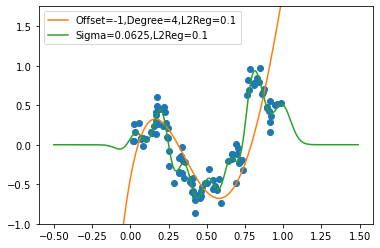

In [20]:
###Code provided in the assignment###

## Plot the best polynomial and RBF fits you found
plot_step = .01
xpts = np.arange(-.5 , 1.5, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
#Plot best polynomial fit
offset= -1
degree = 4
l2reg = 0.1
k = functools.partial(polynomial_kernel, offset=offset, degree=degree)
f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
label = "Offset="+str(offset)+",Degree="+str(degree)+",L2Reg="+str(l2reg)
plt.plot(xpts, f.predict(xpts), label=label)
#Plot best RBF fit
sigma = 0.0625
l2reg= 0.1
k = functools.partial(RBF_kernel, sigma=sigma)
f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.75)
plt.show()

Comment: the RBF kernel with the optimized hyperparameters provided a great fit to the data. In comparison, the polynomial kernel provided a worse fit. This is reflected in their respective mean square error values.